In [13]:
import importlib
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

import utility_v1
import propagators_v1
import energy_landscapes_v1

import parallel_simulations_v1
import weighted_ensemble_v1
import metadynamics_v1

#methods for fast print debugging #<---- these probably belong in utility_v1.py
def p(x):
    print(x)
def pl(x):
    print(len(x))
def ps(x):
    print(x.shape)

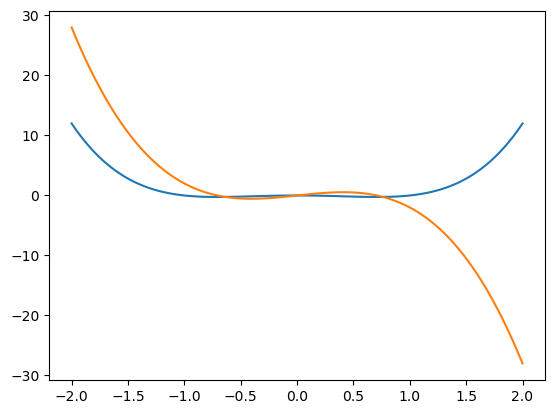

In [14]:
kT = 1
dt = 0.001

importlib.reload(energy_landscapes_v1)

system1 = energy_landscapes_v1.unit_double_well()
system1.plot_quantity(system1.potential)
system1.plot_quantity(system1.F)
plt.show()


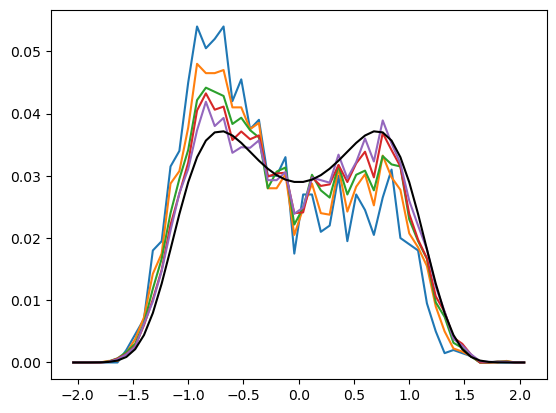

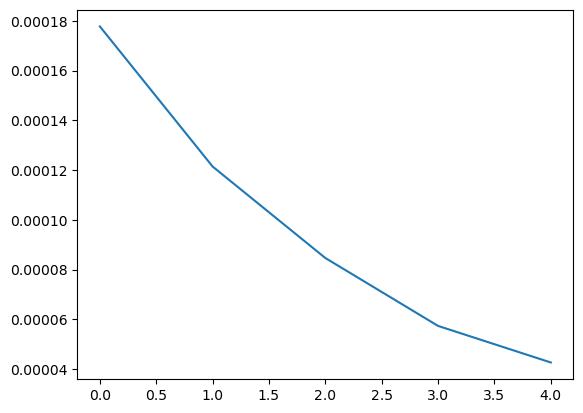

In [51]:
importlib.reload(utility_v1)
importlib.reload(propagators_v1)
importlib.reload(energy_landscapes_v1)

importlib.reload(parallel_simulations_v1)
importlib.reload(weighted_ensemble_v1)
importlib.reload(metadynamics_v1)

#hyperparameters for estimating convergence
n_timepoints = 5
n_bootstrap = 3

#binning parameters
n_analysis_bins = 50
#save frequency
save_period = 100 #in steps

#simulation time limits
aggregate_simulation_limit = 1000000
molecular_time_limit = 10000

n_parallel = int(round(aggregate_simulation_limit/molecular_time_limit))
nsteps = int(round(aggregate_simulation_limit/(n_parallel*n_timepoints)))

binbounds, bincenters, step = system1.analysis_bins_1d(n_analysis_bins)

est_state_pop_convergence_parallel, maew_convergence_parallel = parallel_simulations_v1.sampler_parallel_hist(system1, n_parallel, nsteps, save_period, n_timepoints, kT, dt, binbounds, bincenters)

#plot results
pops_norm, energies_norm = system1.normalized_pops_energies(kT, bincenters)

for espc in est_state_pop_convergence_parallel:
    plt.plot(bincenters, espc)

plt.plot(bincenters, pops_norm, color="black")
plt.show()

plt.plot(maew_convergence_parallel)
plt.show()

In [ ]:

#---------------------------------------------------------------------------------------------------------------------------

# #bin boundaries along each dimension
# binbounds = [np.linspace(system1.standard_analysis_range[0][0], system1.standard_analysis_range[1][0], 14+1),
#              np.linspace(system1.standard_analysis_range[0][1], system1.standard_analysis_range[1][1], 6+1)]

# #get true populations
# state_bins = msm_trj_analysis.bin_to_voxels_msmstates(binbounds, system1.x)
# state_pops = msm_trj_analysis.state_to_bin_populations(state_bins, system1.p)

# #run sampler
# est_state_pop_convergence_we, maew_convergence_we = weighted_ensemble_4.sampler_we_hist(system1, int(nsteps/10), n_timepoints, kT, dt, binbounds)
# est_state_pop_convergence_parallel, maew_convergence_parallel = msm_trj_long_simulation.sampler_parallel_hist(system1, n_parallel, nsteps, save_period, n_timepoints, kT, dt, binbounds)

# #plot results
# for espc in est_state_pop_convergence_parallel:
#     plt.plot(espc)

# plt.plot(state_pops, color="black")
# plt.show()

# #plot results
# for espc in est_state_pop_convergence_we:
#     plt.plot(espc)

# plt.plot(state_pops, color="black")
# plt.show()

# plt.plot(maew_convergence_parallel)
# plt.plot(maew_convergence_we)
# plt.show()